#### Passive Land Mines Detection and Classification Method with Hybrid Machine-Learning Models.

### Data Preparation and Preprocessing

In [127]:

import pandas as pd
import numpy as np

import xgboost as xgb

import pickle

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [128]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

In [129]:
import mlflow

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("mlops-experiment")

2024/07/24 15:00:08 INFO mlflow.tracking.fluent: Experiment with name 'mlops-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1721851208957, experiment_id='1', last_update_time=1721851208957, lifecycle_stage='active', name='mlops-experiment', tags={}>

In [130]:
# read the data and get 10 samples of the data

df = pd.read_csv("Mine_Dataset.csv")
df.sample(10)

,V,H,S,M
171,0.233988,0.727273,0.4,4
271,0.444108,0.909091,1.0,2
52,0.610271,0.636364,0.0,2
149,0.347432,0.636364,0.6,4
175,0.416918,0.181818,1.0,4
229,0.365861,0.090909,0.6,1
330,0.519637,0.090909,0.4,5
200,0.332326,0.636364,0.2,5
258,0.480362,0.454545,0.2,2
246,0.259093,0.363636,1.0,1


In [131]:
# rename the columns

df = df.rename(
    columns={"V": "voltage", "H": "height", "S": "soil_types", "M": "mine_types"}
)
df.head()

,voltage,height,soil_types,mine_types
0,0.338157,0.000000,0.0,1
1,0.320241,0.181818,0.0,1
2,0.287009,0.272727,0.0,1
3,0.256284,0.454545,0.0,1
4,0.262840,0.545455,0.0,1


In [132]:
# check missing data in the dataframe

df.isnull().sum()

voltage       0
height        0
soil_types    0
mine_types    0
dtype: int64

In [133]:
# full information about our dataset.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   voltage     338 non-null    float64
 1   height      338 non-null    float64
 2   soil_types  338 non-null    float64
 3   mine_types  338 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 10.7 KB


In [134]:
# statistical data of the dataframe

df.describe()

,voltage,height,soil_types,mine_types
count,338.000000,338.000000,338.000000,338.000000
mean,0.430634,0.508876,0.503550,2.952663
std,0.195819,0.306043,0.344244,1.419703
min,0.197734,0.000000,0.000000,1.000000
25%,0.309737,0.272727,0.200000,2.000000
50%,0.359516,0.545455,0.600000,3.000000
75%,0.482628,0.727273,0.800000,4.000000
max,0.999999,1.000000,1.000000,5.000000


In [135]:
# Unique values of mine types and soil types in the dataframe

df["mine_types"] = df["mine_types"].replace({1: 0, 2: 1, 3: 2, 4: 3, 5: 4})
df["mine_types"].value_counts(), df["soil_types"].value_counts()

(mine_types
 0    71
 1    70
 2    66
 3    66
 4    65
 Name: count, dtype: int64,
 soil_types
 0.0    59
 0.8    58
 0.6    57
 1.0    57
 0.4    56
 0.2    51
 Name: count, dtype: int64)

### Data Visualization and Interpretation

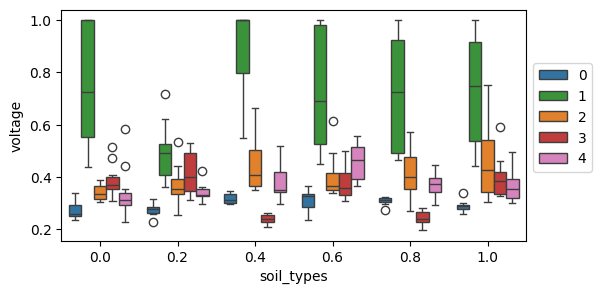

In [136]:
plt.figure(figsize=(6, 3))
palette = {0: "tab:blue", 1: "tab:green", 2: "tab:orange", 3: "tab:red", 4: "tab:pink"}
sns.boxplot(data=df, x="soil_types", y="voltage", hue="mine_types", palette=palette)
plt.legend(bbox_to_anchor=(1, 0.8))

* ##### The boxplot above indicates Anti-Tank land mines has the highest voltage on all soil types.

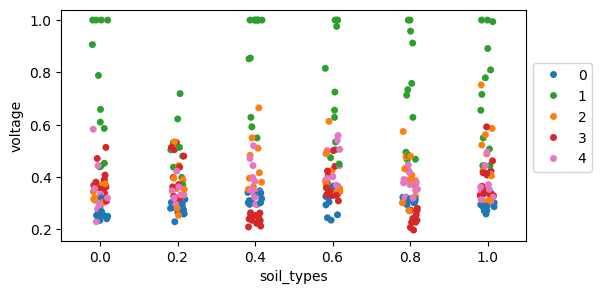

In [137]:
plt.figure(figsize=(6, 3))
sns.stripplot(
    data=df, x="soil_types", y="voltage", hue="mine_types", jitter=True, palette=palette
)
plt.legend(bbox_to_anchor=(1, 0.8))

##### Removing Outliers from the dataframe

In [138]:
# df greater than 25%

Q1 = df.quantile(0.25)
Q1

voltage       0.309737
height        0.272727
soil_types    0.200000
mine_types    1.000000
Name: 0.25, dtype: float64

In [139]:
# df less than 75%

Q3 = df.quantile(0.75)
Q3

voltage       0.482628
height        0.727273
soil_types    0.800000
mine_types    3.000000
Name: 0.75, dtype: float64

In [140]:
# Inter-quantile range

IQR = Q3 - Q1
IQR

voltage       0.172891
height        0.454545
soil_types    0.600000
mine_types    2.000000
dtype: float64

In [141]:
# removed outliers reduced entries from 338 to 306

df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]
df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 306 entries, 0 to 337
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   voltage     306 non-null    float64
 1   height      306 non-null    float64
 2   soil_types  306 non-null    float64
 3   mine_types  306 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 12.0 KB


##### get both categorical and numerical variables from the dataframe columns

In [142]:
df.columns

Index(['voltage', 'height', 'soil_types', 'mine_types'], dtype='object')

In [143]:
num_variables = ["voltage", "height"]
cat_variable = ["soil_types"]

In [144]:
# convert the categorical variable from float to string dtypes

df[cat_variable] = df[cat_variable].astype(str)
df[cat_variable].dtypes

soil_types    object
dtype: object

In [145]:
df[num_variables].dtypes

voltage    float64
height     float64
dtype: object

#### Setting Up The Validation Framework

In [146]:
# Get Test data:  test_size=0.2, which is the 20% of full dataset

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [147]:
# get the train_test and validation_test: 20% of df_val of the 80% of df_train = 0.25 == 20/80 == 1/4

df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [148]:
# shuffle the indexes of each dataframe

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [149]:
# target values for each dataframe in numpy array

y_train = df_train["mine_types"].values
y_val = df_val["mine_types"].values
y_test = df_test["mine_types"].values

In [150]:
# delete target variable

del df_train["mine_types"]
del df_val["mine_types"]
del df_test["mine_types"]

In [151]:
# Explore df_full_train

df_full_train = df_full_train.reset_index(drop=True)
df_full_train.isnull().sum()

voltage       0
height        0
soil_types    0
mine_types    0
dtype: int64

In [152]:
df_full_train["mine_types"].value_counts(), df_full_train["mine_types"].value_counts(
    normalize=True
)

(mine_types
 0    59
 3    57
 4    49
 2    49
 1    30
 Name: count, dtype: int64,
 mine_types
 0    0.241803
 3    0.233607
 4    0.200820
 2    0.200820
 1    0.122951
 Name: proportion, dtype: float64)

In [153]:
# length of the split datasets

len(df_full_train), len(df_train), len(df_val), len(df_test)

(244, 183, 61, 62)

#### Feature Importance/Correlation

In [154]:
corr = df_full_train[cat_variable + num_variables].corrwith(df_full_train["mine_types"])
corr.sort_values(ascending=False)

voltage       0.084134
soil_types    0.003797
height       -0.034109
dtype: float64

#### One Hot Encoding with Dictvectorizer

In [155]:
num_variables = ["voltage", "height"]
cat_variable = ["soil_types"]

dv = DictVectorizer(sparse=False)

# convert train data to dictionary
train_dicts = df_train[cat_variable + num_variables].to_dict(orient="records")

# feature matrices for the training data.
X_train = dv.fit_transform(train_dicts)

# convert validation data to dictionary
val_dicts = df_val[cat_variable + num_variables].to_dict(orient="records")

# the feature matrices for the validation dataset
X_val = dv.transform(val_dicts)

In [156]:
dv.get_feature_names_out()

array(['height', 'soil_types=0.0', 'soil_types=0.2', 'soil_types=0.4',
       'soil_types=0.6', 'soil_types=0.8', 'soil_types=1.0', 'voltage'],
      dtype=object)

In [157]:
# Evaluation function of auc_score for individual target


def roc_auc_score_multiclass(actual_class, pred_class, average="macro"):

    # creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:

        # creating a list of all the classes except the current class
        other_class = [x for x in unique_class if x != per_class]

        # marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        # using scikit-learn method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average=average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

##### Tracking experiments of different ML Hybrid Models for multi-class target(Mine_types)

##### 1. Random Forest without hyperparamter tuning

In [158]:
# estimator object of RF algorithm

model_RF = RandomForestClassifier()

In [159]:
# Training the RF model

model_RF.fit(X_train, y_train)

RandomForestClassifier()

In [160]:
# Prediction without any parameter tuning

y_pred = model_RF.predict(X_val)

In [161]:
# Evaluate the model_RF without hyperparamter tuning

accuracy = (y_val == y_pred).mean()
print(f"Model_RF accuracy: {accuracy}")

# roc_auc_score of individual mine-types without tuned RF selected parameters

roc_auc_score_RF = roc_auc_score_multiclass(y_val, y_pred)
print(f"Model_RF roc_auc_score : {roc_auc_score_RF}")

Model_RF accuracy: 0.5081967213114754
Model_RF roc_auc_score : {0: 0.8094919786096256, 1: 0.8125, 2: 0.5263636363636364, 3: 0.7451923076923077, 4: 0.5008503401360543}


In [162]:
# saving the RF model without tuned paramters

with open("models/model_RF.bin", "wb") as f_out:
    pickle.dump((dv, model_RF), f_out)

#### logging Random Forest Classifier into mlflow 

In [163]:
with mlflow.start_run():

    mlflow.set_tag("developer", "Emmanuel")

    mlflow.log_param("train-data", df_train)
    mlflow.log_param("val-data-path", df_val)

    model_RF = RandomForestClassifier()
    model_RF.fit(X_train, y_train)

    y_pred = model_RF.predict(X_val)

    accuracy = (y_val == y_pred).mean()

    roc_auc_score_RF = roc_auc_score_multiclass(y_val, y_pred)

    mlflow.sklearn.log_model(model_RF, artifact_path="model-RF")

    mlflow.log_artifact(
        local_path="models/model_RF.bin", artifact_path="model-dicvectorizer"
    )

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("roc_auc_score_0", roc_auc_score_RF[0])
    mlflow.log_metric("roc_auc_score_1", roc_auc_score_RF[1])
    mlflow.log_metric("roc_auc_score_2", roc_auc_score_RF[2])
    mlflow.log_metric("roc_auc_score_3", roc_auc_score_RF[3])
    mlflow.log_metric("roc_auc_score_4", roc_auc_score_RF[4])

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/07/24 15:02:13 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under mlflow-artifacts:/1/667d05d867544ed891ce241ebebecefb/artifacts. Set logging level to DEBUG via `logging.getLogg

#### Hyperparameter tuning of Random Forest Classifier:

* ##### Randomized search RF hyperparameter tuning

In [164]:
%%time

# randomly selected hyperparamters for tuning the RF model
RF_params_grid = {
    "n_estimators": range(1, 10),
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": range(1, 10),
    "min_samples_split": np.linspace(0.1, 0.5),
    "min_samples_leaf": np.linspace(0.1, 0.5),
    "min_weight_fraction_leaf": np.linspace(0.1, 0.5),
    "max_features": ["sqrt", "log2"],
    "min_impurity_decrease": np.linspace(0.1, 0.5),
    "random_state": range(1, 6),
    "verbose": range(1, 6),
    "class_weight": ["balanced", "balanced_subsample"],
    "ccp_alpha": np.linspace(0.1, 0.5),
    "bootstrap": [True, False],
    "warm_start": [True, False],
    "oob_score": [True, False],
}

CPU times: user 1.25 ms, sys: 0 ns, total: 1.25 ms
Wall time: 1.5 ms


In [165]:
# estimator object of the RF tuning algorithm
model_RF1 = RandomizedSearchCV(estimator=model_RF, param_distributions=RF_params_grid)

In [166]:
# Training the Randomized search RF algorithm
model_RF1.fit(X_train, y_train)

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(
/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the cla

building tree 1 of 1
building tree 1 of 1
building tree 1 of 1
building tree 1 of 1
building tree 1 of 1
building tree 1 of 3
building tree 2 of 3
building tree 3 of 3
building tree 1 of 3
building tree 2 of 3
building tree 3 of 3
building tree 1 of 3
building tree 2 of 3
building tree 3 of 3
building tree 1 of 3
building tree 2 of 3
building tree 3 of 3
building tree 1 of 3
building tree 2 of 3
building tree 3 of 3
building tree 1 of 9
building tree 2 of 9
building tree 3 of 9
building tree 4 of 9
building tree 5 of 9
building tree 6 of 9
building tree 7 of 9
building tree 8 of 9
building tree 9 of 9
building tree 1 of 9
building tree 2 of 9
building tree 3 of 9
building tree 4 of 9
building tree 5 of 9
building tree 6 of 9
building tree 7 of 9
building tree 8 of 9
building tree 9 of 9
building tree 1 of 9
building tree 2 of 9
building tree 3 of 9
building tree 4 of 9
building tree 5 of 9
building tree 6 of 9
building tree 7 of 9
building tree 8 of 9
building tree 9 of 9
building tree

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(
/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the cla

building tree 1 of 9
building tree 2 of 9
building tree 3 of 9
building tree 4 of 9
building tree 5 of 9
building tree 6 of 9
building tree 7 of 9
building tree 8 of 9
building tree 9 of 9
building tree 1 of 3
building tree 2 of 3
building tree 3 of 3
building tree 1 of 3
building tree 2 of 3
building tree 3 of 3
building tree 1 of 3
building tree 2 of 3
building tree 3 of 3
building tree 1 of 3
building tree 2 of 3
building tree 3 of 3
building tree 1 of 3
building tree 2 of 3
building tree 3 of 3
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(
/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the cla

RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'bootstrap': [True, False],
                                        'ccp_alpha': array([0.1       , 0.10816327, 0.11632653, 0.1244898 , 0.13265306,
       0.14081633, 0.14897959, 0.15714286, 0.16530612, 0.17346939,
       0.18163265, 0.18979592, 0.19795918, 0.20612245, 0.21428571,
       0.22244898, 0.23061224, 0.23877551, 0.24693878, 0.25510204,
       0.26326531, 0.271428...
       0.30408163, 0.3122449 , 0.32040816, 0.32857143, 0.33673469,
       0.34489796, 0.35306122, 0.36122449, 0.36938776, 0.37755102,
       0.38571429, 0.39387755, 0.40204082, 0.41020408, 0.41836735,
       0.42653061, 0.43469388, 0.44285714, 0.45102041, 0.45918367,
       0.46734694, 0.4755102 , 0.48367347, 0.49183673, 0.5       ]),
                                        'n_estimators': range(1, 10),
                                        'oob_score': [True, False],
                                        'random_state': range(1, 6),
                                        'verbose': range(1, 6),
                                        'warm_start': [True, False]})

In [167]:
# best params for Randomized search RF
RFCV_params = model_RF1.best_params_
RFCV_params

{'warm_start': True,
 'verbose': 4,
 'random_state': 4,
 'oob_score': False,
 'n_estimators': 4,
 'min_weight_fraction_leaf': 0.3938775510204082,
 'min_samples_split': 0.5,
 'min_samples_leaf': 0.23877551020408164,
 'min_impurity_decrease': 0.14081632653061227,
 'max_features': 'log2',
 'max_depth': 7,
 'criterion': 'log_loss',
 'class_weight': 'balanced',
 'ccp_alpha': 0.17346938775510207,
 'bootstrap': True}

In [168]:
with mlflow.start_run():

    mlflow.set_tag("developer", "Emmanuel")

    mlflow.log_param("train-data", df_train)
    mlflow.log_param("val-data-path", df_val)

    # best params from Randomized search RF
    RFCV_params = {
        "warm_start": False,
        "verbose": 3,
        "random_state": 5,
        "oob_score": True,
        "n_estimators": 7,
        "min_weight_fraction_leaf": 0.4510204081632654,
        "min_samples_split": 0.3448979591836735,
        "min_samples_leaf": 0.2551020408163266,
        "min_impurity_decrease": 0.1326530612244898,
        "max_features": "log2",
        "max_depth": 7,
        "criterion": "entropy",
        "class_weight": "balanced_subsample",
        "ccp_alpha": 0.1653061224489796,
        "bootstrap": True,
    }

    mlflow.log_params(RFCV_params)

    model_RF1 = RandomizedSearchCV(
        estimator=model_RF, param_distributions=RF_params_grid
    )
    model_RF1.fit(X_train, y_train)
    mlflow.sklearn.log_model(model_RF1, artifact_path="model_RF1")

    y_pred1 = model_RF1.predict(X_val)

    accuracy = (y_val == y_pred1).mean()

    roc_auc_score_RF = roc_auc_score_multiclass(y_val, y_pred1)

    mlflow.log_artifact(
        local_path="models/model_RF1.bin", artifact_path="model-dicvectorizer"
    )

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("roc_auc_score_0", roc_auc_score_RF[0])
    mlflow.log_metric("roc_auc_score_1", roc_auc_score_RF[1])
    mlflow.log_metric("roc_auc_score_2", roc_auc_score_RF[2])
    mlflow.log_metric("roc_auc_score_3", roc_auc_score_RF[3])
    mlflow.log_metric("roc_auc_score_4", roc_auc_score_RF[4])

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(
/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start i

building tree 1 of 4
building tree 2 of 4
building tree 3 of 4
building tree 4 of 4
building tree 1 of 4
building tree 2 of 4
building tree 3 of 4
building tree 4 of 4
building tree 1 of 4
building tree 2 of 4
building tree 3 of 4
building tree 4 of 4
building tree 1 of 4
building tree 2 of 4
building tree 3 of 4
building tree 4 of 4
building tree 1 of 4
building tree 2 of 4
building tree 3 of 4
building tree 4 of 4
building tree 1 of 6
building tree 2 of 6
building tree 3 of 6
building tree 4 of 6
building tree 5 of 6
building tree 6 of 6
building tree 1 of 6
building tree 2 of 6
building tree 3 of 6
building tree 4 of 6
building tree 5 of 6
building tree 6 of 6
building tree 1 of 6
building tree 2 of 6
building tree 3 of 6
building tree 4 of 6
building tree 5 of 6
building tree 6 of 6
building tree 1 of 6
building tree 2 of 6
building tree 3 of 6
building tree 4 of 6
building tree 5 of 6
building tree 6 of 6
building tree 1 of 6
building tree 2 of 6
building tree 3 of 6
building tree

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(
/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start i

building tree 1 of 7
building tree 2 of 7
building tree 3 of 7
building tree 4 of 7
building tree 5 of 7
building tree 6 of 7
building tree 7 of 7
building tree 1 of 7
building tree 2 of 7
building tree 3 of 7
building tree 4 of 7
building tree 5 of 7
building tree 6 of 7
building tree 7 of 7
building tree 1 of 7
building tree 2 of 7
building tree 3 of 7
building tree 4 of 7
building tree 5 of 7
building tree 6 of 7
building tree 7 of 7
building tree 1 of 7
building tree 2 of 7
building tree 3 of 7
building tree 4 of 7
building tree 5 of 7
building tree 6 of 7
building tree 7 of 7
building tree 1 of 7
building tree 2 of 7
building tree 3 of 7
building tree 4 of 7
building tree 5 of 7
building tree 6 of 7
building tree 7 of 7
building tree 1 of 3
building tree 2 of 3
building tree 3 of 3
building tree 1 of 3
building tree 2 of 3
building tree 3 of 3
building tree 1 of 3
building tree 2 of 3
building tree 3 of 3
building tree 1 of 3
building tree 2 of 3
building tree 3 of 3
building tree

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(
/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start i

building tree 9 of 9
building tree 1 of 7
building tree 2 of 7
building tree 3 of 7
building tree 4 of 7
building tree 5 of 7
building tree 6 of 7
building tree 7 of 7


/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/07/24 15:03:41 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under mlflow-artifacts:/1/0c515a499d2d41f6a618a1d18db65393/artifacts. Set logging level to DEBUG via `logging.getLogg

* ##### RF hyperopt hyperparameters tuning

In [169]:
# define objective function
def objective(params):
    RF_HYP = RandomForestClassifier(**params)
    accuracy = cross_val_score(RF_HYP, X_train, y_train, cv=5).mean()
    return {"loss": -accuracy, "status": STATUS_OK}

In [179]:
# Define the hyperparameter space for RF
space = {
    "n_estimators": hp.choice("n_estimators", range(1, 10)),
    "max_depth": hp.choice("max_depth", range(1, 10)),
    "min_samples_split": hp.uniform("min_samples_split", 0.1, 0.5),
    "min_samples_leaf": hp.uniform("min_samples_leaf", 0.1, 0.5),
    "criterion": hp.choice("criterion", ["gini", "entropy", "log_loss"]),
    "min_weight_fraction_leaf": hp.uniform("min_weight_fraction_leaf", 0.1, 0.5),
    "max_features": hp.choice("max_features", ["sqrt", "log2"]),
    "min_impurity_decrease": hp.uniform("min_impurity_decrease", 0.1, 0.5),
    "random_state": hp.choice("random_state", range(1, 6)),
    "verbose": hp.choice("verbose", range(1, 6)),
    "class_weight": hp.choice("class_weight", ["balanced", "balanced_subsample"]),
    "ccp_alpha": hp.uniform("ccp_alpha", 0.1, 0.5),
    "warm_start": hp.choice("warm_start", [True, False]),
    "oob_score": hp.choice("oob_score", [True, False]),
}

In [180]:
%%time

# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

building tree 1 of 5                                  
building tree 2 of 5                                  
  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

building tree 3 of 5                                  
building tree 4 of 5                                  
building tree 5 of 5                                  
building tree 1 of 5                                  
building tree 2 of 5                                  
building tree 3 of 5                                  
building tree 4 of 5                                  
building tree 5 of 5                                  
building tree 1 of 5                                  
building tree 2 of 5                                  
building tree 3 of 5                                  
building tree 4 of 5                                  
building tree 5 of 5                                  
building tree 1 of 5                                  
  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(



building tree 2 of 5                                  
building tree 3 of 5                                  
building tree 4 of 5                                  
building tree 5 of 5                                  
building tree 1 of 5                                  
building tree 2 of 5                                  
building tree 3 of 5                                  
building tree 4 of 5                                  
building tree 5 of 5                                  
building tree 1 of 5                                                             
building tree 2 of 5                                                             
  5%|▌         | 1/20 [00:00<00:10,  1.75trial/s, best loss: -0.2018018018018018]

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as

building tree 3 of 5                                                             
building tree 4 of 5                                                             
building tree 5 of 5                                                             
building tree 1 of 5                                                             
building tree 2 of 5                                                             
building tree 3 of 5                                                             
building tree 4 of 5                                                             
building tree 5 of 5                                                             
building tree 1 of 5                                                             
building tree 2 of 5                                                             
building tree 3 of 5                                                             
building tree 4 of 5                                                             
building tree 5 

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the cl

building tree 4 of 5                                                             
building tree 5 of 5                                                             
building tree 1 of 9                                                             
building tree 2 of 9                                                             
building tree 3 of 9                                                             
building tree 4 of 9                                                             
building tree 5 of 9                                                             
building tree 6 of 9                                                             
building tree 7 of 9                                                             
building tree 8 of 9                                                             
building tree 9 of 9                                                             
building tree 1 of 9                                                             
building tree 2 

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(



building tree 7 of 9
building tree 8 of 9                                                             
building tree 9 of 9                                                             
building tree 1 of 9                                                             
building tree 2 of 9                                                             
building tree 3 of 9                                                             
building tree 4 of 9                                                             
building tree 5 of 9                                                             
building tree 6 of 9                                                             
building tree 7 of 9                                                             
building tree 8 of 9                                                             
building tree 9 of 9                                                             
building tree 1 of 9                                                         

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(



building tree 8 of 9                                                             
building tree 9 of 9                                                             
building tree 1 of 4                                                             
building tree 2 of 4                                                             
building tree 3 of 4                                                             
building tree 4 of 4                                                             
building tree 1 of 4                                                             
building tree 2 of 4                                                             
 20%|██        | 4/20 [00:01<00:07,  2.02trial/s, best loss: -0.3387387387387387]

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(



building tree 3 of 4                                                             
building tree 4 of 4                                                             
building tree 1 of 4                                                             
building tree 2 of 4                                                             
building tree 3 of 4                                                             
building tree 4 of 4                                                             
building tree 1 of 4                                                             
building tree 2 of 4                                                             
building tree 3 of 4                                                             
building tree 4 of 4                                                             
building tree 1 of 4                                                             
building tree 2 of 4                                                             
building tree 3 

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(



building tree 2 of 5                                                             
building tree 3 of 5                                                             
building tree 4 of 5                                                             
building tree 5 of 5                                                             
building tree 1 of 5                                                             
building tree 2 of 5                                                             
building tree 3 of 5                                                             
building tree 4 of 5                                                             
building tree 5 of 5                                                             
building tree 1 of 5                                                             
building tree 2 of 5                                                             
building tree 3 of 5                                                             
building tree 4 

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start

building tree 2 of 4
building tree 3 of 4                                                             
building tree 4 of 4                                                             
building tree 1 of 6                                                             
building tree 2 of 6                                                             
building tree 3 of 6                                                             
building tree 4 of 6                                                             
building tree 5 of 6                                                             
building tree 6 of 6                                                             
building tree 1 of 6                                                             
building tree 2 of 6                                                             
building tree 3 of 6                                                             
building tree 4 of 6                                                         

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(



building tree 1 of 6                                                             
building tree 2 of 6                                                             
building tree 3 of 6                                                             
building tree 4 of 6                                                             
building tree 5 of 6                                                             
building tree 6 of 6                                                             
building tree 1 of 6                                                             
building tree 2 of 6                                                             
building tree 3 of 6                                                             
building tree 4 of 6                                                             
building tree 5 of 6                                                             
building tree 6 of 6                                                             
building tree 1 

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(

/home/bluemusk/anaco

building tree 1 of 1                                                             
building tree 1 of 5                                                             
building tree 2 of 5                                                             
building tree 3 of 5                                                             
building tree 4 of 5                                                             
building tree 5 of 5                                                             
building tree 1 of 5                                                             
building tree 2 of 5                                                             
building tree 3 of 5                                                             
building tree 4 of 5                                                             
building tree 5 of 5                                                             
building tree 1 of 5                                                             
building tree 2 

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as

building tree 1 of 5
building tree 2 of 5                                                             
building tree 3 of 5                                                             
building tree 4 of 5                                                             
building tree 5 of 5                                                             
building tree 1 of 5                                                             
building tree 2 of 5                                                             
building tree 3 of 5                                                             
building tree 4 of 5                                                             
building tree 5 of 5                                                             
 50%|█████     | 10/20 [00:03<00:02,  3.73trial/s, best loss: -0.3387387387387387]

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the cl

building tree 1 of 3                                                              
building tree 2 of 3                                                              
building tree 3 of 3                                                              
building tree 1 of 3                                                              
building tree 2 of 3                                                              
building tree 3 of 3                                                              
building tree 1 of 3                                                              
building tree 2 of 3                                                              
building tree 3 of 3                                                              
building tree 1 of 3                                                              
building tree 2 of 3                                                              
building tree 3 of 3                                                              
buil

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute

building tree 1 of 6                                                              
building tree 2 of 6                                                              
building tree 3 of 6                                                              
building tree 4 of 6                                                              
building tree 5 of 6                                                              
building tree 6 of 6                                                              
building tree 1 of 6                                                              
building tree 2 of 6                                                              
building tree 3 of 6                                                              
building tree 4 of 6                                                              
building tree 5 of 6                                                              
building tree 6 of 6                                                              
buil

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute

building tree 5 of 6
building tree 6 of 6                                                              
building tree 1 of 6                                                              
building tree 2 of 6                                                              
building tree 3 of 6                                                              
building tree 4 of 6                                                              
building tree 5 of 6                                                              
building tree 6 of 6                                                              
building tree 1 of 6                                                              
building tree 2 of 6                                                              
building tree 3 of 6                                                              
building tree 4 of 6                                                              
building tree 5 of 6                                              

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute

building tree 1 of 7                                                              
building tree 2 of 7                                                              
building tree 3 of 7                                                              
building tree 4 of 7                                                              
building tree 5 of 7                                                              
building tree 6 of 7                                                              
building tree 7 of 7                                                              
building tree 1 of 7                                                              
building tree 2 of 7                                                              
building tree 3 of 7                                                              
building tree 4 of 7                                                              
building tree 5 of 7                                                              
buil

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the cl

building tree 7 of 7                                                              
building tree 1 of 7                                                              
building tree 2 of 7                                                              
building tree 3 of 7                                                              
building tree 4 of 7                                                              
building tree 5 of 7                                                              
building tree 6 of 7                                                              
building tree 7 of 7                                                              
building tree 1 of 7                                                              
building tree 2 of 7                                                              
building tree 3 of 7                                                              
building tree 4 of 7                                                              
buil

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the cl

building tree 7 of 7                                                              
building tree 1 of 6                                                              
building tree 2 of 6                                                              
building tree 3 of 6                                                              
building tree 4 of 6                                                              
building tree 5 of 6                                                              
building tree 6 of 6                                                              
building tree 1 of 6                                                              
building tree 2 of 6                                                              
building tree 3 of 6                                                              
building tree 4 of 6                                                              
building tree 5 of 6                                                              
buil

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start

building tree 1 of 6                                                              
building tree 2 of 6                                                              
building tree 3 of 6                                                              
building tree 4 of 6                                                              
building tree 5 of 6                                                              
building tree 6 of 6                                                              
building tree 1 of 6                                                              
building tree 2 of 6                                                              
building tree 3 of 6                                                              
building tree 4 of 6                                                              
building tree 5 of 6                                                              
building tree 6 of 6                                                              
buil

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute

building tree 4 of 4                                                              
building tree 1 of 4                                                              
building tree 2 of 4                                                              
building tree 3 of 4                                                              
building tree 4 of 4                                                              
building tree 1 of 4                                                              
building tree 2 of 4                                                              
building tree 3 of 4                                                              
building tree 4 of 4                                                              
building tree 1 of 4                                                              
building tree 2 of 4                                                              
building tree 3 of 4                                                              
buil

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the cl

building tree 1 of 7                                                              
building tree 2 of 7                                                              
building tree 3 of 7                                                              
building tree 4 of 7                                                              
building tree 5 of 7                                                              
building tree 6 of 7                                                              
building tree 7 of 7                                                              
building tree 1 of 7                                                              
building tree 2 of 7                                                              
building tree 3 of 7                                                              
building tree 4 of 7                                                              
building tree 5 of 7                                                              
buil

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the cl

building tree 2 of 7                                                              
building tree 3 of 7                                                              
building tree 4 of 7                                                              
building tree 5 of 7                                                              
building tree 6 of 7                                                              
building tree 7 of 7                                                              
building tree 1 of 7                                                              
building tree 2 of 7                                                              
building tree 3 of 7                                                              
building tree 4 of 7                                                              
building tree 5 of 7                                                              
building tree 6 of 7                                                              
buil

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the cl

building tree 1 of 4                                                              
building tree 2 of 4                                                              
building tree 3 of 4                                                              
building tree 4 of 4                                                              
building tree 1 of 4                                                              
building tree 2 of 4                                                              
building tree 3 of 4                                                              
building tree 4 of 4                                                              
building tree 1 of 4                                                              
 80%|████████  | 16/20 [00:08<00:02,  1.95trial/s, best loss: -0.3442942942942943]

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute

building tree 2 of 4                                                              
building tree 3 of 4                                                              
building tree 4 of 4                                                              
building tree 1 of 7                                                              
building tree 2 of 7                                                              
building tree 3 of 7                                                              
building tree 4 of 7                                                              
building tree 5 of 7                                                              
building tree 6 of 7                                                              
building tree 7 of 7                                                              
building tree 1 of 7                                                              
building tree 2 of 7                                                              
buil

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute

building tree 1 of 7                                                              
building tree 2 of 7                                                              
building tree 3 of 7                                                              
building tree 4 of 7                                                              
building tree 5 of 7                                                              
building tree 6 of 7                                                              
building tree 7 of 7                                                              
building tree 1 of 7                                                              
building tree 2 of 7                                                              
building tree 3 of 7                                                              
building tree 4 of 7                                                              
building tree 5 of 7                                                              
buil

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute

building tree 7 of 9                                                              
building tree 8 of 9                                                              
building tree 9 of 9                                                              
building tree 1 of 9                                                              
building tree 2 of 9                                                              
building tree 3 of 9                                                              
building tree 4 of 9                                                              
building tree 5 of 9                                                              
building tree 6 of 9                                                              
building tree 7 of 9                                                              
building tree 8 of 9                                                              
building tree 9 of 9                                                              
buil

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the cl

building tree 4 of 9                                                              
building tree 5 of 9                                                              
building tree 6 of 9                                                              
building tree 7 of 9                                                              
building tree 8 of 9                                                              
building tree 9 of 9                                                              
building tree 1 of 9                                                              
building tree 2 of 9                                                              
building tree 3 of 9                                                              
building tree 4 of 9                                                              
building tree 5 of 9                                                              
building tree 6 of 9                                                              
buil

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute

In [181]:
# Print the best hyperparameters
print("Best hyperparameters of hyperopt tuned RF found:")
print(best)

Best hyperparameters of hyperopt tuned RF found:
{'ccp_alpha': 0.2673088314955542, 'class_weight': 1, 'criterion': 1, 'max_depth': 3, 'max_features': 1, 'min_impurity_decrease': 0.2531032679632811, 'min_samples_leaf': 0.1859966139629175, 'min_samples_split': 0.11763670084395611, 'min_weight_fraction_leaf': 0.2772049570024571, 'n_estimators': 6, 'oob_score': 1, 'random_state': 2, 'verbose': 1, 'warm_start': 0}


In [182]:
best

{'ccp_alpha': 0.2673088314955542,
 'class_weight': 1,
 'criterion': 1,
 'max_depth': 3,
 'max_features': 1,
 'min_impurity_decrease': 0.2531032679632811,
 'min_samples_leaf': 0.1859966139629175,
 'min_samples_split': 0.11763670084395611,
 'min_weight_fraction_leaf': 0.2772049570024571,
 'n_estimators': 6,
 'oob_score': 1,
 'random_state': 2,
 'verbose': 1,
 'warm_start': 0}

In [183]:
# Map Hyperopt indices to actual values
RFHYP_best_params = {
    "n_estimators": best["n_estimators"],
    "max_depth": best["max_depth"],
    "min_samples_split": best["min_samples_split"],
    "min_samples_leaf": best["min_samples_leaf"],
    "max_features": ["sqrt", "log2"][best["max_features"]],
    "min_impurity_decrease": best["min_impurity_decrease"],
    "min_weight_fraction_leaf": best["min_weight_fraction_leaf"],
    "oob_score": [True, False][best["oob_score"]],
    "random_state": best["random_state"],
    "verbose": best["verbose"],
    "warm_start": [True, False][best["warm_start"]],
    "criterion": ["gini", "entropy", "log_loss"][best["criterion"]],
    "ccp_alpha": best["ccp_alpha"],
    "class_weight": ["balanced", "balanced_subsample"][best["class_weight"]],
}

In [184]:
# Fit the RF model with the best parameters
model_RF2 = RandomForestClassifier(**RFHYP_best_params)
model_RF2.fit(X_train, y_train)

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(


RandomForestClassifier(ccp_alpha=0.2673088314955542,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=3, max_features='log2',
                       min_impurity_decrease=0.2531032679632811,
                       min_samples_leaf=0.1859966139629175,
                       min_samples_split=0.11763670084395611,
                       min_weight_fraction_leaf=0.2772049570024571,
                       n_estimators=6, random_state=2, verbose=1,
                       warm_start=True)

In [185]:
# Make predictions with RF_HYP tuned parameters
y_pred2 = model_RF2.predict(X_val)
y_pred2

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [186]:
# Evaluate the model_RFHYP with hyperparamter tuned RF
accuracy = (y_val == y_pred2).mean()
print(f"Model_RF2 accuracy: {accuracy}")

Model_RF2 accuracy: 0.4098360655737705


In [187]:
# roc_auc_score of individual mine-types with hyperopt tuned RF selected parameters
roc_auc_score_RF2 = roc_auc_score_multiclass(y_val, y_pred2)
print(f"Model_RF2 roc_auc_score : {roc_auc_score_RF2}")

Model_RF2 roc_auc_score : {0: 0.6704545454545454, 1: 0.9339622641509434, 2: 0.5, 3: 0.5, 4: 0.5}


In [188]:
with mlflow.start_run():

    mlflow.set_tag("developer", "Emmanuel")

    mlflow.log_param("train-data", df_train)
    mlflow.log_param("val-data-path", df_val)

    # best params from Randomized search RF

    RFHYP_best_params = {
        "n_estimators": best["n_estimators"],
        "max_depth": best["max_depth"],
        "min_samples_split": best["min_samples_split"],
        "min_samples_leaf": best["min_samples_leaf"],
        "max_features": ["sqrt", "log2"][best["max_features"]],
        "min_impurity_decrease": best["min_impurity_decrease"],
        "min_weight_fraction_leaf": best["min_weight_fraction_leaf"],
        "oob_score": [True, False][best["oob_score"]],
        "random_state": best["random_state"],
        "verbose": best["verbose"],
        "warm_start": [True, False][best["warm_start"]],
        "criterion": ["gini", "entropy", "log_loss"][best["criterion"]],
        "ccp_alpha": best["ccp_alpha"],
        "class_weight": ["balanced", "balanced_subsample"][best["class_weight"]],
    }

    mlflow.log_params(RFHYP_best_params)

    model_RF2 = RandomForestClassifier(**RFHYP_best_params)
    model_RF2.fit(X_train, y_train)
    mlflow.sklearn.log_model(model_RF2, artifact_path="model_RF2")

    y_pred2 = model_RF2.predict(X_val)

    accuracy = (y_val == y_pred2).mean()

    roc_auc_score_RF = roc_auc_score_multiclass(y_val, y_pred2)

    mlflow.log_artifact(
        local_path="models/model_RF2.bin", artifact_path="model-dicvectorizer"
    )

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("roc_auc_score_0", roc_auc_score_RF[0])
    mlflow.log_metric("roc_auc_score_1", roc_auc_score_RF[1])
    mlflow.log_metric("roc_auc_score_2", roc_auc_score_RF[2])
    mlflow.log_metric("roc_auc_score_3", roc_auc_score_RF[3])
    mlflow.log_metric("roc_auc_score_4", roc_auc_score_RF[4])

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(
/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure th

#### 2. XGBoost

In [189]:
# set config for xgb boost
xgb.set_config(verbosity=0)

* ##### tuning XGBclassifier selected hyperparameters with randomized search from scikit-learn

In [190]:
model_xgb = xgb.XGBClassifier()

In [191]:
# randomly selected xgboost parameters
xgb_params_grid = {
    "n_estimators": range(5, 50, 5),
    "max_depth": range(1, 10),
    "learning_rate": np.linspace(0.01, 1),
    "subsample": np.linspace(0.01, 1),
    "colsample_bytree": np.linspace(0.01, 1),
    "gamma": np.linspace(0.01, 1),
    "reg_alpha": range(1, 10),
    "reg_lambda": range(1, 10),
    "min_child_weight": range(1, 10),
    "objective": ["multi:softmax"],
    "n_thread": range(1, 10),
    "silent": range(1, 10),
    "num_class": [5],
}

In [192]:
# XGBclassifier algorithm randomized search hyper-parameters tuning
model_xgb1 = RandomizedSearchCV(
    estimator=model_xgb, param_distributions=xgb_params_grid, error_score="raise"
)

In [193]:
# fit the randomized search XGBclassifier model
model_xgb1.fit(X_train, y_train)

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(error_score='raise',
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=Non...
       0.31306122, 0.33326531, 0.35346939, 0.37367347, 0.39387755,
       0.41408163, 0.43428571, 0.4544898 , 0.47469388, 0.49489796,
       0.51510204, 0.53530612, 0.5555102 , 0.57571429, 0.59591837,
       0.61612245, 0.63632653, 0.65653061, 0.67673469, 0.69693878,
       0.71714286, 0.73734694, 0.75755102, 0.7777551 , 0.79795918,
       0.81816327, 0.83836735, 0.85857143, 0.87877551, 0.89897959,
       0.91918367, 0.93938776, 0.95959184, 0.97979592, 1.        ])})

In [194]:
# best estimators of randomized search XGBClassifier model
model_xgb1.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5555102040816327, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.4746938775510204,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.676734693877551,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=35, n_jobs=None, n_thread=3,
              num_class=5, ...)

In [195]:
# best tuned hyper parameters of XGBClassifier
xgbCV_params = model_xgb1.best_params_
xgbCV_params

{'subsample': 0.7171428571428571,
 'silent': 4,
 'reg_lambda': 2,
 'reg_alpha': 4,
 'objective': 'multi:softmax',
 'num_class': 5,
 'n_thread': 3,
 'n_estimators': 35,
 'min_child_weight': 7,
 'max_depth': 9,
 'learning_rate': 0.676734693877551,
 'gamma': 0.4746938775510204,
 'colsample_bytree': 0.5555102040816327}

In [196]:
# prediction with the selected randomized search XGBClassifier model
y_pred3 = model_xgb1.predict(X_val)
y_pred3

array([1, 3, 0, 3, 2, 0, 3, 3, 2, 3, 0, 1, 2, 0, 3, 3, 3, 2, 1, 0, 0, 0,
       0, 1, 2, 0, 3, 1, 0, 1, 2, 2, 2, 2, 0, 3, 3, 3, 0, 3, 0, 3, 3, 3,
       0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0], dtype=int32)

In [197]:
# Evaluate the model_xgbCV with randomized search hyperparamter tuned paramters
accuracy = (y_val == y_pred3).mean()
print(f"Model_xgb1 accuracy: {accuracy}")

Model_xgb1 accuracy: 0.4426229508196721


In [198]:
# roc_auc_score of individual target with tuned XGBClassifier parameters
roc_auc_score_xgb1 = roc_auc_score_multiclass(y_val, y_pred3)
print(f"Model_xgb1 roc_auc_score : {roc_auc_score_xgb1}")

Model_xgb1 roc_auc_score : {0: 0.8048128342245988, 1: 0.9375, 2: 0.4654545454545454, 3: 0.5080128205128205, 4: 0.5}


In [199]:
with mlflow.start_run():

    mlflow.set_tag("developer", "Emmanuel")

    mlflow.log_param("train-data", df_train)
    mlflow.log_param("val-data-path", df_val)

    # best params from Randomized search RF
    xgbCV_params = {
        "subsample": 1.0,
        "silent": 2,
        "reg_lambda": 5,
        "reg_alpha": 2,
        "objective": "multi:softmax",
        "num_class": 5,
        "n_thread": 8,
        "n_estimators": 45,
        "min_child_weight": 2,
        "max_depth": 5,
        "learning_rate": 0.11102040816326529,
        "gamma": 0.49489795918367346,
        "colsample_bytree": 0.8787755102040816,
    }

    mlflow.log_params(xgbCV_params)

    model_xgb1 = RandomizedSearchCV(
        estimator=model_xgb, param_distributions=xgb_params_grid, error_score="raise"
    )
    model_xgb1.fit(X_train, y_train)
    mlflow.sklearn.log_model(model_xgb1, artifact_path="model_xgb1")

    y_pred3 = model_xgb1.predict(X_val)

    accuracy = (y_val == y_pred3).mean()

    roc_auc_score_xgb1 = roc_auc_score_multiclass(y_val, y_pred3)

    mlflow.log_artifact(
        local_path="models/model_RF1.bin", artifact_path="model-dicvectorizer"
    )

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("roc_auc_score_0", roc_auc_score_RF[0])
    mlflow.log_metric("roc_auc_score_1", roc_auc_score_RF[1])
    mlflow.log_metric("roc_auc_score_2", roc_auc_score_RF[2])
    mlflow.log_metric("roc_auc_score_3", roc_auc_score_RF[3])
    mlflow.log_metric("roc_auc_score_4", roc_auc_score_RF[4])

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/07/24 15:07:43 WARNING mlflow.models.model: Logging model metadata to the tr

* ##### hyperopt hyperparameters tuning of XGBoost from Native interface

In [200]:
# DMatrix data structure to train xgboost faster
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [201]:
# Define the objective function
def objective(params):
    params["max_depth"] = int(
        params["max_depth"]
    )  # XGBoost requires max_depth to be an integer
    dtrain = xgb.DMatrix(X_train, label=y_train)
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=100,
        nfold=5,
        metrics="mlogloss",
        early_stopping_rounds=10,
    )
    best_score = cv_results["test-mlogloss-mean"].min()
    return {"loss": best_score, "status": STATUS_OK}

In [202]:
# Define the hyperparameter space
search_space = {
    "max_depth": hp.choice("max_depth", range(1, 10)),
    "learning_rate": hp.uniform("learning_rate", 0.01, 0.1),
    "subsample": hp.uniform("subsample", 0.01, 1.0),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.01, 1.0),
    "gamma": hp.uniform("gamma", 0.01, 1),
    "reg_alpha": hp.uniform("reg_alpha", 0.01, 1.0),
    "reg_lambda": hp.uniform("reg_lambda", 0.01, 1.0),
    "objective": "multi:softmax",
    "num_class": 5,
    "n_estimators": hp.choice("n_estimators", range(5, 50, 5)),
    "min_child_weight": hp.choice("min_child_weight", range(1, 10)),
    "silent": hp.choice("silent", range(1, 10)),
    "nthread": hp.choice("nthread", range(1, 10)),
}

In [203]:
%%time
# Run the optimization
trials = Trials()
best = fmin(
    fn=objective, space=search_space, algo=tpe.suggest, max_evals=20, trials=trials
)

100%|██████████| 20/20 [00:23<00:00,  1.17s/trial, best loss: 1.247119966404395]
CPU times: user 24.2 s, sys: 22 s, total: 46.2 s
Wall time: 23.4 s


In [204]:
# Print the best hyperparameters
print("Best hyperparameters of hyperopt-tuned XGB found:")
print(best)

Best hyperparameters of hyperopt-tuned XGB found:
{'colsample_bytree': 0.7566185126899699, 'gamma': 0.94994646664921, 'learning_rate': 0.08081649011757691, 'max_depth': 8, 'min_child_weight': 0, 'n_estimators': 6, 'nthread': 4, 'reg_alpha': 0.39938395391708675, 'reg_lambda': 0.32385972289959297, 'silent': 3, 'subsample': 0.73267486118763}


In [205]:
best

{'colsample_bytree': 0.7566185126899699,
 'gamma': 0.94994646664921,
 'learning_rate': 0.08081649011757691,
 'max_depth': 8,
 'min_child_weight': 0,
 'n_estimators': 6,
 'nthread': 4,
 'reg_alpha': 0.39938395391708675,
 'reg_lambda': 0.32385972289959297,
 'silent': 3,
 'subsample': 0.73267486118763}

In [206]:
# Map Hyperopt results to parameter space
xgbHYP_best_params = {
    "max_depth": int(best["max_depth"]),
    "learning_rate": best["learning_rate"],
    "reg_alpha": best["reg_alpha"],
    "reg_lambda": best["reg_lambda"],
    "subsample": best["subsample"],
    "colsample_bytree": best["colsample_bytree"],
    "gamma": best["gamma"],
    "min_child_weight": best["min_child_weight"],
    "silent": best["silent"],
    "nthread": best["nthread"],
    "n_estimators": best["n_estimators"],
}

In [207]:
# Fit the model with the best parameters
model_xgb2 = xgb.train(xgbHYP_best_params, dtrain, num_boost_round=100)

In [208]:
# Make predictions
y_pred4 = model_xgb2.predict(dval)

In [209]:
# Evaluate the model_xgbHYP with hyperopt hyperparamters
accuracy = (y_val == y_pred4).mean()
print(f"Model_xgb2 accuracy: {accuracy}")

Model_xgb2 accuracy: 0.0


In [210]:
# roc_auc_score of individual target with tuned hyperopt parameters
roc_auc_score_xgb2 = roc_auc_score_multiclass(y_val, y_pred4)
print(f"Model_xgb2 roc_auc_score : {roc_auc_score_xgb2}")

Model_xgb2 roc_auc_score : {0: 0.5, 1: 0.5, 2: 0.5, 3: 0.5, 4: 0.5}


In [211]:
with mlflow.start_run():

    mlflow.set_tag("developer", "Emmanuel")

    mlflow.log_param("train-data", df_train)
    mlflow.log_param("val-data-path", df_val)

    xgbHYP_best_params = {
        "max_depth": int(best["max_depth"]),
        "learning_rate": best["learning_rate"],
        "reg_alpha": best["reg_alpha"],
        "reg_lambda": best["reg_lambda"],
        "subsample": best["subsample"],
        "colsample_bytree": best["colsample_bytree"],
        "gamma": best["gamma"],
        "min_child_weight": best["min_child_weight"],
        "silent": best["silent"],
        "nthread": best["nthread"],
        "n_estimators": best["n_estimators"],
    }
    mlflow.log_params(xgbHYP_best_params)

    model_xgb2 = xgb.train(xgbHYP_best_params, dtrain, num_boost_round=100)

    mlflow.sklearn.log_model(model_xgb2, artifact_path="model_xgb2")

    y_pred4 = model_xgb2.predict(dval)

    accuracy = (y_val == y_pred4).mean()

    roc_auc_score_xgb2 = roc_auc_score_multiclass(y_val, y_pred4)

    mlflow.log_artifact(
        local_path="models/model_xgb2.bin", artifact_path="model-dicvectorizer"
    )

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("roc_auc_score_0", roc_auc_score_RF[0])
    mlflow.log_metric("roc_auc_score_1", roc_auc_score_RF[1])
    mlflow.log_metric("roc_auc_score_2", roc_auc_score_RF[2])
    mlflow.log_metric("roc_auc_score_3", roc_auc_score_RF[3])
    mlflow.log_metric("roc_auc_score_4", roc_auc_score_RF[4])

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/07/24 15:09:28 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under mlflow-artifacts:/1/2ebde0404bc54eac800ac97b18d86bf4/artifacts. Set logging level to DEBUG via `logging.getLogg

#### 3. Support Vector Machine Classifier

In [212]:
# Define the objective function
def objective(params):
    # Ensure degree is an integer
    params["degree"] = int(params["degree"])

    clf = SVC(**params)
    accuracy = cross_val_score(clf, X_train, y_train, cv=5).mean()
    return {"loss": -accuracy, "status": STATUS_OK}

In [213]:
# Define the hyperparameter space
space = {
    "C": hp.loguniform("C", np.log(0.001), np.log(1000)),
    "kernel": hp.choice("kernel", ["linear", "poly", "rbf", "sigmoid"]),
    "degree": hp.choice("degree", range(1, 6)),  # for 'poly' kernel
    "gamma": hp.choice("gamma", ["scale", "auto"]),
    "coef0": hp.uniform("coef0", 0, 10),  # for 'poly' and 'sigmoid' kernels
    "tol": hp.loguniform("tol", np.log(0.001), np.log(1000)),
    "cache_size": hp.choice("cache_size", range(100, 600)),
    "decision_function_shape": hp.choice("decision_function_shape", ["ovr", "ovo"]),
}

In [214]:
%%time
# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

100%|██████████| 20/20 [00:01<00:00, 12.27trial/s, best loss: -0.6124624624624624]
CPU times: user 1.72 s, sys: 12.6 ms, total: 1.73 s
Wall time: 1.72 s


In [215]:
# Map Hyperopt results to parameter space
SVC_best_params = {
    "C": best["C"],
    "kernel": ["linear", "poly", "rbf", "sigmoid"][best["kernel"]],
    "degree": best["degree"],
    "gamma": ["scale", "auto"][best["gamma"]],
    "coef0": best["coef0"],
    "tol": best["tol"],
    "cache_size": best["cache_size"],
    "decision_function_shape": ["ovr", "ovo"][best["decision_function_shape"]],
}

In [216]:
# Print the best hyperparameters
print("Best hyperparameters of hyperopt-tuned SVC found:")
print(best)

Best hyperparameters of hyperopt-tuned SVC found:
{'C': 474.53829636873206, 'cache_size': 360, 'coef0': 9.882459883038827, 'decision_function_shape': 1, 'degree': 0, 'gamma': 0, 'kernel': 2, 'tol': 0.11160900625634604}


In [217]:
# Fit the model with the best parameters
model_SVC = SVC(**SVC_best_params)
model_SVC.fit(X_train, y_train)

SVC(C=474.53829636873206, cache_size=360, coef0=9.882459883038827,
    decision_function_shape='ovo', degree=0, tol=0.11160900625634604)

In [218]:
# Make predictions with SVC best parameters
y_pred5 = model_SVC.predict(X_val)

In [219]:
# Evaluate the SVC model
accuracy = (y_val == y_pred5).mean()
print(f"Model_SVC accuracy: {accuracy}")

Model_SVC accuracy: 0.6557377049180327


In [220]:
# roc_auc_score of individual target with tuned SVC parameters
roc_auc_score_SVC = roc_auc_score_multiclass(y_val, y_pred5)
print(f"Model_SVC roc_auc_score : {roc_auc_score_SVC}")

Model_SVC roc_auc_score : {0: 0.7981283422459893, 1: 1.0, 2: 0.6063636363636363, 3: 0.8325320512820512, 4: 0.6777210884353742}


In [221]:
with mlflow.start_run():

    mlflow.set_tag("developer", "Emmanuel")

    mlflow.log_param("train-data", df_train)
    mlflow.log_param("val-data-path", df_val)

    SVC_best_params = {
        "C": best["C"],
        "kernel": ["linear", "poly", "rbf", "sigmoid"][best["kernel"]],
        "degree": best["degree"],
        "gamma": ["scale", "auto"][best["gamma"]],
        "coef0": best["coef0"],
        "tol": best["tol"],
        "cache_size": best["cache_size"],
        "decision_function_shape": ["ovr", "ovo"][best["decision_function_shape"]],
    }

    mlflow.log_params(SVC_best_params)

    model_SVC = SVC(**SVC_best_params)
    model_SVC.fit(X_train, y_train)

    mlflow.sklearn.log_model(model_SVC, artifact_path="model-SVC")

    y_pred5 = model_SVC.predict(X_val)

    accuracy = (y_val == y_pred5).mean()

    roc_auc_score_SVC = roc_auc_score_multiclass(y_val, y_pred5)

    mlflow.log_artifact(
        local_path="models/model_SVC.bin", artifact_path="model-dicvectorizer"
    )

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("roc_auc_score_0", roc_auc_score_RF[0])
    mlflow.log_metric("roc_auc_score_1", roc_auc_score_RF[1])
    mlflow.log_metric("roc_auc_score_2", roc_auc_score_RF[2])
    mlflow.log_metric("roc_auc_score_3", roc_auc_score_RF[3])
    mlflow.log_metric("roc_auc_score_4", roc_auc_score_RF[4])

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/07/24 15:11:49 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under mlflow-artifacts:/1/9e0f00a306034f07a88d9039004d931e/artifacts. Set logging level to DEBUG via `logging.getLogg

#### 4. MultiLayer Perceptron Classifier

In [222]:
# Define the objective function
def objective(params):
    clf = MLPClassifier(**params, max_iter=2000)
    accuracy = cross_val_score(clf, X_train, y_train, cv=5).mean()
    return {"loss": -accuracy, "status": STATUS_OK}

In [223]:
# Define the hyperparameter space
space = {
    "hidden_layer_sizes": hp.choice(
        "hidden_layer_sizes", [(50,), (100,), (50, 50), (100, 50)]
    ),
    "activation": hp.choice("activation", ["identity", "logistic", "tanh", "relu"]),
    "solver": hp.choice("solver", ["lbfgs", "sgd", "adam"]),
    "alpha": hp.loguniform("alpha", np.log(1e-5), np.log(1e-2)),
    "learning_rate": hp.choice("learning_rate", ["constant", "invscaling", "adaptive"]),
    "learning_rate_init": hp.loguniform(
        "learning_rate_init", np.log(0.001), np.log(0.005)
    ),
    "power_t": hp.uniform("power_t", 0.1, 0.5),
    "tol": hp.loguniform("tol", np.log(0.0001), np.log(0.0005)),
    "momentum": hp.uniform("momentum", 0.1, 0.9),
    "beta_1": hp.uniform("beta_1", 0.1, 0.9),
    "beta_2": hp.uniform("beta_2", 0.111, 0.999),
    "epsilon": hp.loguniform("epsilon", np.log(1e-08), np.log(1e-04)),
    "n_iter_no_change": hp.choice("n_iter_no_change", range(10, 20)),
    "max_fun": hp.choice("max_fun", range(10000, 20000)),
}

In [224]:
%%time
# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

 15%|█▌        | 3/20 [00:05<00:29,  1.72s/trial, best loss: -0.5903903903903903]

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optim

 20%|██        | 4/20 [00:08<00:36,  2.26s/trial, best loss: -0.5903903903903903]

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|██████    | 12/20 [00:23<00:13,  1.73s/trial, best loss: -0.6175675675675676]

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optim

 80%|████████  | 16/20 [00:29<00:04,  1.21s/trial, best loss: -0.6175675675675676]

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



 85%|████████▌ | 17/20 [00:33<00:06,  2.18s/trial, best loss: -0.6175675675675676]

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.p

 90%|█████████ | 18/20 [00:37<00:05,  2.50s/trial, best loss: -0.6175675675675676]

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



 95%|█████████▌| 19/20 [00:38<00:02,  2.21s/trial, best loss: -0.6175675675675676]

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|██████████| 20/20 [00:50<00:00,  2.51s/trial, best loss: -0.6175675675675676]
CPU times: user 1min 20s, sys: 1min 40s, total: 3min
Wall time: 51.8 s


In [225]:
# Map Hyperopt results to parameter space
MLP_best_params = {
    "hidden_layer_sizes": [(50,), (100,), (50, 50), (100, 50)][
        best["hidden_layer_sizes"]
    ],
    "activation": ["identity", "logistic", "tanh", "relu"][best["activation"]],
    "solver": ["lbfgs", "sgd", "adam"][best["solver"]],
    "alpha": best["alpha"],
    "learning_rate": ["constant", "invscaling", "adaptive"][best["learning_rate"]],
    "learning_rate_init": best["learning_rate_init"],
    "power_t": best["power_t"],
    "tol": best["tol"],
    "momentum": best["momentum"],
    "beta_1": best["beta_1"],
    "beta_2": best["beta_2"],
    "epsilon": best["epsilon"],
    "n_iter_no_change": best["n_iter_no_change"],
    "max_fun": best["max_fun"],
}

In [226]:
# Print the best hyperparameters
print("Best hyperparameters of hyperopt-tuned MLP found:")
print(best)

Best hyperparameters of hyperopt-tuned MLP found:
{'activation': 2, 'alpha': 1.9898605413729316e-05, 'beta_1': 0.1055790126998085, 'beta_2': 0.2151028571948885, 'epsilon': 3.402551780960441e-06, 'hidden_layer_sizes': 3, 'learning_rate': 0, 'learning_rate_init': 0.003153506301369204, 'max_fun': 8971, 'momentum': 0.4740816684328667, 'n_iter_no_change': 4, 'power_t': 0.31566404890635436, 'solver': 0, 'tol': 0.00036979559433149544}


In [227]:
# Fit the model with the best parameters
model_MLP = MLPClassifier(**MLP_best_params, max_iter=2000)
model_MLP.fit(X_train, y_train)

MLPClassifier(activation='tanh', alpha=1.9898605413729316e-05,
              beta_1=0.1055790126998085, beta_2=0.2151028571948885,
              epsilon=3.402551780960441e-06, hidden_layer_sizes=(100, 50),
              learning_rate_init=0.003153506301369204, max_fun=8971,
              max_iter=2000, momentum=0.4740816684328667, n_iter_no_change=4,
              power_t=0.31566404890635436, solver='lbfgs',
              tol=0.00036979559433149544)

In [228]:
# Make predictions
y_pred6 = model_MLP.predict(X_val)

In [229]:
# Evaluate the model_xgbCV with hyperparamter tuned paramters
accuracy = (y_val == y_pred6).mean()
print(f"Model_MLP accuracy: {accuracy}")

Model_MLP accuracy: 0.639344262295082


In [230]:
# roc_auc_score of individual target with tuned XGBClassifier parameters
roc_auc_score_MLP = roc_auc_score_multiclass(y_val, y_pred6)
print(f"Model_xgbCV roc_auc_score : {roc_auc_score_MLP}")

Model_xgbCV roc_auc_score : {0: 0.854946524064171, 1: 0.9905660377358491, 2: 0.631818181818182, 3: 0.7764423076923077, 4: 0.6267006802721089}


In [231]:
with mlflow.start_run():

    mlflow.set_tag("developer", "Emmanuel")

    mlflow.log_param("train-data", df_train)
    mlflow.log_param("val-data-path", df_val)

    MLP_best_params = {
        "hidden_layer_sizes": [(50,), (100,), (50, 50), (100, 50)][
            best["hidden_layer_sizes"]
        ],
        "activation": ["identity", "logistic", "tanh", "relu"][best["activation"]],
        "solver": ["lbfgs", "sgd", "adam"][best["solver"]],
        "alpha": best["alpha"],
        "learning_rate": ["constant", "invscaling", "adaptive"][best["learning_rate"]],
        "learning_rate_init": best["learning_rate_init"],
        "power_t": best["power_t"],
        "tol": best["tol"],
        "momentum": best["momentum"],
        "beta_1": best["beta_1"],
        "beta_2": best["beta_2"],
        "epsilon": best["epsilon"],
        "n_iter_no_change": best["n_iter_no_change"],
        "max_fun": best["max_fun"],
    }
    mlflow.log_params(MLP_best_params)

    model_MLP = MLPClassifier(**MLP_best_params, max_iter=2000)
    model_MLP.fit(X_train, y_train)

    mlflow.sklearn.log_model(model_MLP, artifact_path="model-MLP")

    y_pred6 = model_MLP.predict(X_val)

    accuracy = (y_val == y_pred6).mean()

    roc_auc_score_MLP = roc_auc_score_multiclass(y_val, y_pred6)

    mlflow.log_artifact(
        local_path="models/model_MLP.bin", artifact_path="model-dicvectorizer"
    )

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("roc_auc_score_0", roc_auc_score_RF[0])
    mlflow.log_metric("roc_auc_score_1", roc_auc_score_RF[1])
    mlflow.log_metric("roc_auc_score_2", roc_auc_score_RF[2])
    mlflow.log_metric("roc_auc_score_3", roc_auc_score_RF[3])
    mlflow.log_metric("roc_auc_score_4", roc_auc_score_RF[4])

/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/bluemusk/anaconda3/envs/project-env/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/07/24 15:13:47 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under mlflow-artifacts:/1/f581e11fee78470ebc1e996fd61481b1/artifacts. Set logging level to DEBUG via `logging.getLogg

Note: in the previous jupyter notebook under the notebook folder, the SVC model performed best, but here, the MLP performed best. 